<a href="https://colab.research.google.com/github/alifele/Brain_Computer_Interface-Competition-/blob/master/Subject_based_RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/content/drive/My Drive/EEG_BCI/')
import datafetch
import plotters
import random

In [0]:
import random
from sklearn.model_selection import train_test_split

In [15]:
subj_1 = datafetch.fetch_subject(1)
subj_1.keys()

dict_keys(['test_data', 'train_data_class1', 'train_data_class2', 'train_data_class3', 'train_data_class4'])

In [0]:
def selector_desing(subject):
  selector = []
  for i in subject:
    for j in range(1,5):
      for k in range(18):
        selector.append((i,j,k))

  selector = np.array(selector)
  np.random.shuffle(selector)

  return selector

In [0]:
def selector_desing_test_data(subject):
  selector = []
  for i in subject:
    for j in range(1,5):
      for k in range(18,25):
        selector.append((i,j,k))

  selector = np.array(selector)
  np.random.shuffle(selector)
  return selector

In [74]:
selector = selector_desing([1])
selector.shape

(72, 3)

In [0]:
global indexes
global test_data_indexes
global selector
global selector_test_data
selector_test_data = selector_desing_test_data([1])
selector = selector_desing([1])
indexes = [i for i in range(18)]
test_data_indexes = [i for i in range(18,25)]

In [70]:
selector_test_data.shape

(28, 3)

In [0]:
select = selector[12]

In [0]:
def data_loader(select):
  
  global indexes

  this_trail = select[2]
  index = select[2]
  
  Indexes = indexes.copy()
  Indexes.pop(index)  # so, now Indexes is the array [0,1,2,...,17] with out the this_trial index

  samples = random.sample(Indexes, 11)
  samples += [this_trail]


  data =  np.mean(subj_1['train_data_class{}'.format(select[1])][samples], axis=0)
  label = select[1]
  return data, label

In [0]:
def data_loader_test_data(select):
  
  global test_data_indexes

  this_trail = select[2]
  index = select[2]-18
  
  Indexes = test_data_indexes.copy()

  Indexes.pop(index)  # so, now Indexes is the array [18,19,...,24] with out the this_trial index


  samples = random.sample(Indexes, 3)
  samples += [this_trail]


  data =  np.mean(subj_1['train_data_class{}'.format(select[1])][samples], axis=0)
  label = select[1]
  return data, label

In [63]:
test_select = selector_test_data[7]
test_select, test_select.shape

(array([ 1,  1, 21]), (3,))

In [0]:
data_test, label_test = data_loader_test_data([1,1,24])


In [50]:
data_test.shape

(7200, 63)

In [0]:
from plotters import EEG_plotter

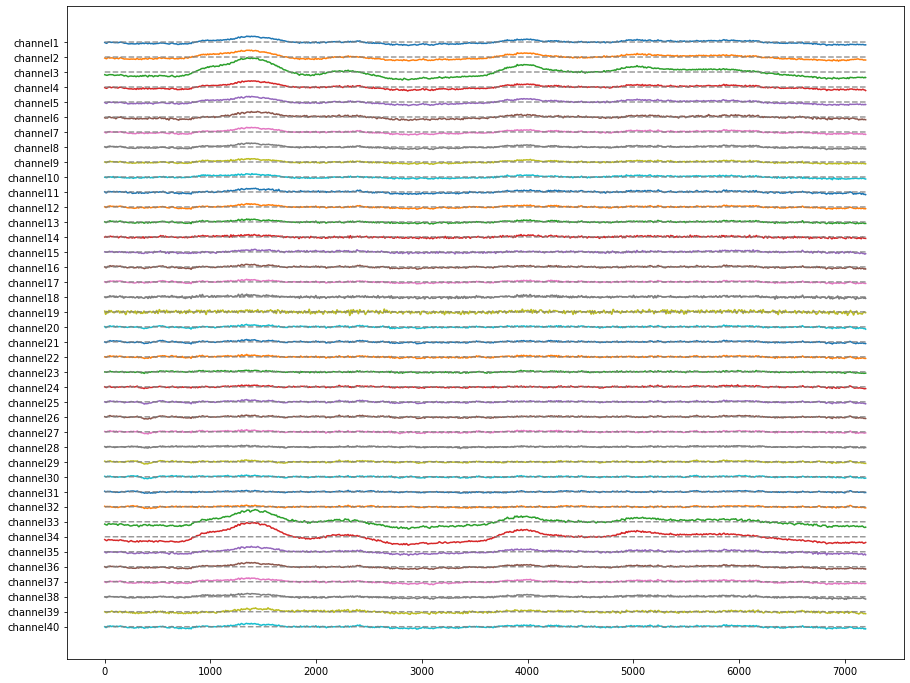

In [67]:
EEG_plotter(40,data)
#The meaned data

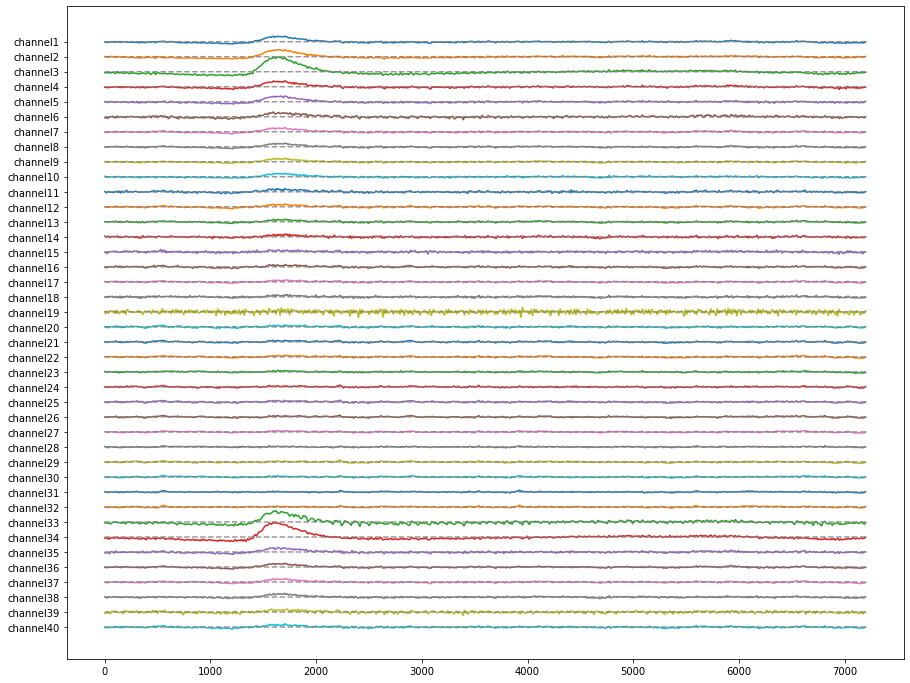

In [68]:
EEG_plotter(40,subj_1['train_data_class{}'.format(select[1])][select[2]] )

# The Unmeaned data

In [0]:
def batch_loader(batch=[0,100]):
  # the batch=[a,b] can be 0...18000*4
  
  Label = []
  Data = []
  global selector
  

  for i in range(batch[0], batch[1]):
    data, label = data_loader(selector[int(i%len(selector))])
    Data.append(data)
    Label.append(label)

  Data = np.array(Data)
  Label = np.array(Label)

  return Data, Label

In [0]:
def batch_loader_test_data(batch=[0,100]):
  # the batch=[a,b] can be 0...35*4
  
  Label = []
  Data = []
  global selector_test_data
  

  for i in range(batch[0], batch[1]):
    data, label = data_loader_test_data(selector_test_data[int(i%len(selector_test_data))])
    Data.append(data)
    Label.append(label)

  Data = np.array(Data)
  Label = np.array(Label)

  return Data, Label

In [0]:
data, label  = batch_loader()

In [102]:
data.shape, label.shape

((100, 7200, 63), (100,))

# The Model

In [0]:
from tensorflow import keras

In [10]:
model = keras.models.Sequential()

#model.add(keras.layers.MaxPool1D(2, input_shape=[None, 63]))
model.add(keras.layers.Conv1D( 20, 80, strides=20, input_shape=[None, 63], activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.GRU(40, return_sequences=True, input_shape =[None, 63]))
model.add(keras.layers.GRU(20))
model.add(keras.layers.Dense(30, activation = 'relu'))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(4, activation ='softmax'))

# This got % accuracy

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [11]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 20)          100820    
_________________________________________________________________
dropout (Dropout)            (None, None, 20)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, None, 40)          7440      
_________________________________________________________________
gru_4 (GRU)                  (None, 20)                3720      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics= ['accuracy'])

In [16]:
intervals = [[500*i,500*(i+1)] for i in range(10)]
for epoch in range(1):
  for interval in intervals:
    data, label = batch_loader(interval)
    X_train, X_val, y_train, y_val = train_test_split(data, label)
    model.fit(X_train, y_train-1, epochs=2, validation_data=(X_val, y_val-1))
    print('')
    print('############################')
    print('############################')
    print('interval:{}    and    epoch:{}'.format(interval, epoch))
    print('############################')
    print('############################')
    print('')

Epoch 1/2
12/12 [==============================] - 3s 222ms/step - loss: 1.2290 - accuracy: 0.4960 - val_loss: 1.1109 - val_accuracy: 0.5920
Epoch 2/2
12/12 [==============================] - 2s 150ms/step - loss: 1.0547 - accuracy: 0.6693 - val_loss: 0.9298 - val_accuracy: 0.6640

############################
############################
interval:[0, 500]    and    epoch:0
############################
############################

Epoch 1/2
12/12 [==============================] - 2s 158ms/step - loss: 0.8667 - accuracy: 0.7147 - val_loss: 0.8604 - val_accuracy: 0.6480
Epoch 2/2
12/12 [==============================] - 2s 156ms/step - loss: 0.6874 - accuracy: 0.7627 - val_loss: 0.7939 - val_accuracy: 0.6960

############################
############################
interval:[500, 1000]    and    epoch:0
############################
############################

Epoch 1/2
12/12 [==============================] - 2s 152ms/step - loss: 0.5424 - accuracy: 0.8560 - val_loss: 0.4571 - val_a

In [0]:
data_test, label_test=  batch_loader_test_data()
data_test2, label_test2 = batch_loader()

In [72]:
model.evaluate(data_test, label_test-1)

4/4 [==============================] - 0s 51ms/step - loss: 3.3076 - accuracy: 0.3700


[3.3076069355010986, 0.3700000047683716]

In [75]:
model.evaluate(data_test2, label_test2-1)

4/4 [==============================] - 0s 45ms/step - loss: 0.1587 - accuracy: 0.9700


[0.15869948267936707, 0.9700000286102295]